In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from IPython.display import clear_output

In [3]:

!pip install split-folders 
clear_output()

In [4]:
!pip install -U keras-tuner

clear_output()

In [5]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

In [6]:
FOLDERS = ["train","val","test"]
DIR_INPUT = "/content/drive/MyDrive/Personal-Project-Datasets/Alzheimer_s Dataset"
DIR_WORK = "./"
DIR_MODELS = os.path.join(DIR_WORK,"models")
DIR_TRAIN = os.path.join(DIR_WORK,"train")
DIR_VAL = os.path.join(DIR_WORK,"val")
DIR_TEST = os.path.join(DIR_WORK,"test")
CLASS_LIST = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']

SEED = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [7]:
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    normal,verymild,mild,moderate =0,0,0,0
    
    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder','normal','verymild','mild','moderate',
                                                        'normal %','verymild %','mild %','moderate %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in FOLDERS:
        for dirname,_, filenames in os.walk(os.path.join(path,folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal+=1
                if "VeryMildDemented" in dirname:
                    verymild+=1
                if 'MildDemented' in dirname:
                    mild+=1
                if 'ModerateDemented' in dirname:
                    moderate+=1
                    
        # calculate total and percentages            
        total = normal+verymild+mild+moderate
        if total >0:
            n  = round(normal/total,2)*100
            vm = round(verymild/total,2)*100
            m  = round(mild/total,2)*100
            mo =round(moderate/total,2)*100
        else:
            n,vm,m,mo = 0,0,0,0
        
        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(folder,normal,verymild,mild,moderate,n,vm,m,mo))
        normal,verymild,mild,moderate =0,0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS) 

folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2560       1792    2509          52     37.0       26.0     36.0          1.0
val           0          0       0           0        0          0        0            0
test        640        448     627          12     37.0       26.0     36.0          1.0


In [8]:
def create_dir(dir_path,folder,verbose=True):
  msg=""
  folder_path = os.path.join(dir_path,folder)

  if not path.exists(folder_path):
    try:
      os.mkdir(folder_path)
      msg = folder_path + " created"
    except OSError as err:
      print("Error creating folder:{} with error:{}".format(folder_path,err))
  if verbose:
    print(msg)
  return folder_path

create_dir(DIR_WORK, "models", True)

'./models'

In [9]:
def resample_train_val_images(input_dir,working_dir,seed="SEED",split=(0.80,0.20)):

  dir_test = os.path.join(input_dir,"test")
  dir_train = os.path.join(input_dir,"train")

  for folder in FOLDERS:
    if path.exists(os.path.join(working_dir, folder)):
      shutil.rmtree(os.path.join(working_dir,folder))

  shutil.copytree(dir_test,os.path.join(working_dir,"test"))

  splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split)

  print("\n Images By Class After Resampling")
  print("-"*67)
  images_by_class(working_dir,FOLDERS)

resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [00:15, 336.05 files/s]


 Images By Class After Resampling
-------------------------------------------------------------------
folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2048       1433    2006          41     37.0       26.0     36.0          1.0
val         512        359     503          11     37.0       26.0     36.0          1.0
test        640        448     627          12     37.0       26.0     36.0          1.0


In [10]:
IMG_SIZE = [176,208]
BATCH_SIZE = 16

# Scale Images
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


# Image Generators
# train images: 4098
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          # convert to rgb
    seed        = SEED 
)

# validation images: 1023
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED
)

# test images:1279
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED,
    shuffle     = False
)

# Training and Validation Steps
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
steps per epoch:255


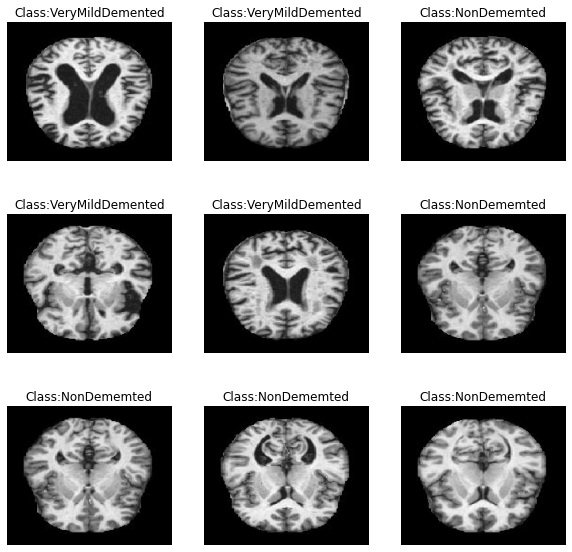

In [11]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_gen)

In [12]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results:
    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkred', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'salmon', label = 'Validation AUC')
    plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkred', linestyle='--')
    plt.legend()

    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [13]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num
    
    """
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")
        
        # set all layers to not trainable
        base.trainable = False

        # loop through all layers from conv#_block# and set to true
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)
                    

In [14]:
# function to build the model
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    Input: a base model, dropout rate, the number of filters in the dense node, 
           the learning rate and performance metrics
    Output: A compiled CNN model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

In [15]:
# training parameters
EPOCHS        = 100
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

234700800/234698864 [==============================] - 3s 0us/step
No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 6, 7, 2048)        58370944  
_________________________________________________________________
dropout (Dropout)            (None, 6, 7, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 7, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 86016)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               44040704  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total par

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


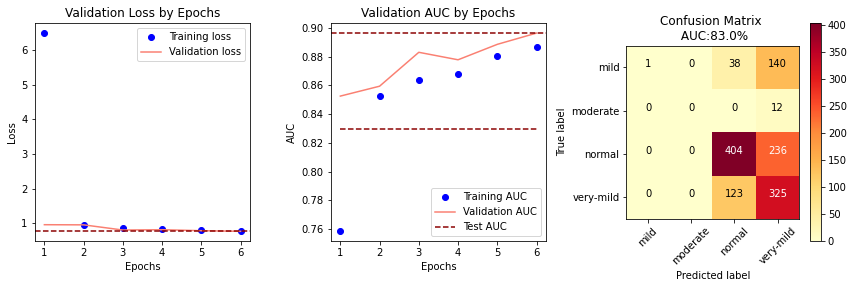

INFO:tensorflow:Assets written to: ./models/base_model/assets
Total Time:5.78


In [16]:
# Train Model: Base Model
# get base
conv_base = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot training metrics
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save the Model
model.save(os.path.join(DIR_MODELS,'base_model'))

# display runtime
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))